## K8 Micrservices Architecture
____

+ Microservices
+ How to setup Microservices in Docker
+ Deploting Microservices in GCP

## Intro

___


Here we going to understand microserves architecture using a simple web application. We going to deplot the application on multiple K8s platformsL GCP and K8 Play Platform.


First we going to see how to deploy it using only docker

(https://github.com/dockersamples/example-voting-app)

We going to use voting app that is the sample app used by docker.


With this app we have two interfaces

1. Allows user to vote
2. Allows use to see the voring results.

Components/Microservices:

1. Vorting App allows the user to make a vote: Cat or Dog. This is written in python.

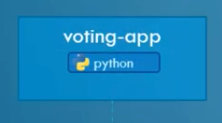

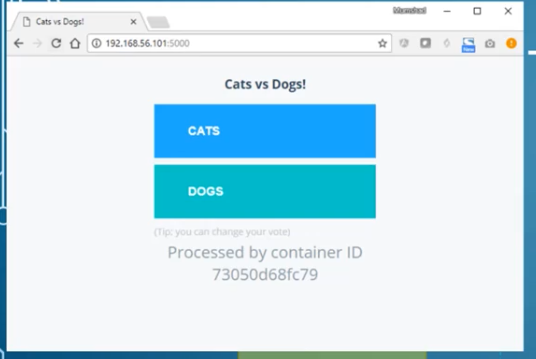


2. Once you made the above selection, the vote is stored in redis, which is an in memory database

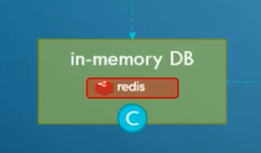

3. The vote is the processed by the worker, which is an app written in .NET

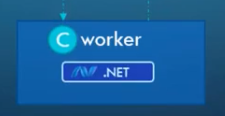

4. The worker then update the vote into a persistent database, postgresql database. The database has a table for the number of votes per category.

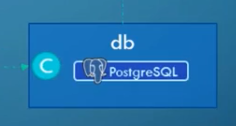

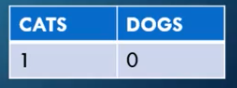



5. This info is displayed in a web interface, which is another microservice app. (results page). The is written in nodejs. Reads the information from postgres and displays it to the user.

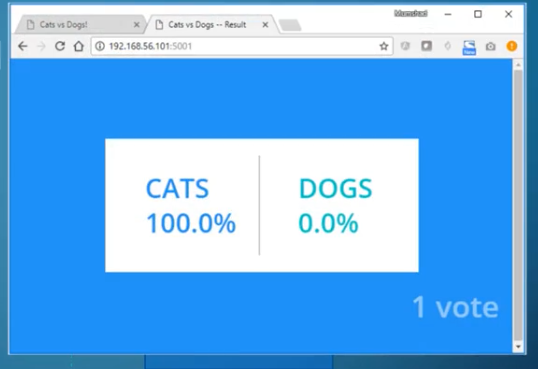


Here is the total app:

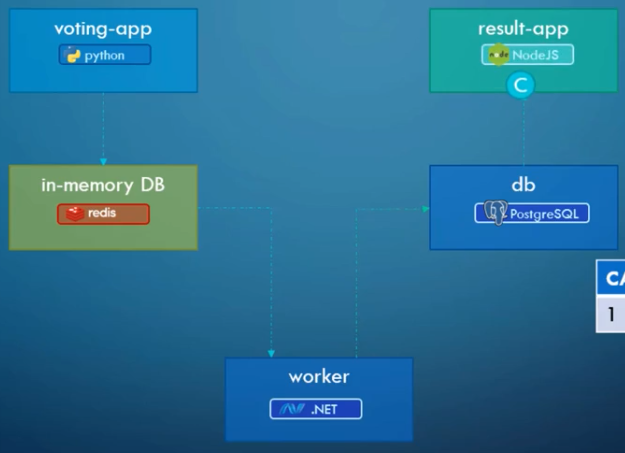







## How to setup Microservices in Docker

____
 
Lets setup this technology stack on a single docker instance, using Docker Run.

So we assume all images are already built....and are on docker hub.

1. Deploy redis, in back ground, pulling redis image, and name the conatainer redis. Naming the conatiner is important

```
docker run -d --name=redis redis

```

2. Deploy postgresql, pull image(postgresql:9.4) and give it a name(db)

```
docker run -d --name=db postgresql:9.4

```

3. Deploy front end web app, pull image(voting-app) and give it a name(vote)

```
docker run -d --name=vote -p 5000:80 voting-app

```


4. Deploy front end web app, pull image(result-app) and give it a name(result)
```
docker run -d --name=result -p 5001:80 result-app

```


4. Deploy front end web app, pull image(worker) and give it a name(worker)
```
docker run -d --name=worker worker

```

so now all the instances are running on the host, but we have a problem...the component does not know about each other...they not connected

The voring app does not know to use this instance of redis.... etc...

Teh worker app does not know to use this postgresql instance etc...

This is where we use links, this is a command line option to LINK two container together.

- Voting app is dependent on Redis service


To make the voting app aware of the redis service, we add a link option, when we run the voying app container.


So we update, so we need to issue the name of the redis CONTAINER(name) in the link:

```
--link redis:redis

```
And will issue:

```
docker run -d --name=vote -p 5000:80  --link redis:redis  voting-app

```

This is why we named the container the first time. What does the link do? What this does it creates an entry in etc/hosts file on the on the voting app container, adding an entry with the name redis, with the internal ip of the redis container.


![MicroServices9.png](attachment:MicroServices9.png)


- Result app is dependent on postgresql database


```

docker run -d --name=result -p 5001:80 --link db:db result-app

```


- Worker app is dependent on redis and postgresql database


```

docker run -d --name=worker --link db:db --link redis:redis  worker

```

Links may be deprecated in future in docker.


## Deploting Microservices in GCP

___

Here we going to deploy application on GCP, that is a Google Container Engine.

We will post the following:

1. Setup a Google Container Engine Environment
2. Create Kubernetes PODs
3. Create Services - ClusterIP -Internal
4. Create Services - LoadBalancer - External

We go to the following site:

https://cloud.google.com/kubernetes-engine?authuser=2

We can get a K8s platform with a single click.

If we click on Getting Started Quickstart..

https://cloud.google.com/gcp/getting-started?authuser=2


Lest log into the console, and go to K8s engine....


Here we wil get the K8s dashoard....click on create cluster., since we do not have any...this brings up a form to create a cluster.


Enter name: voting-app

Leave the rest on default. Click create....


What does this do?

It create a K8s master node, and three (3) worker nodes.

(Wait for creation and see green check mark)

Also click the google cloud shell, which will give me a temporary shell to work with.

This shell allows me to issue k8s commands.

Click on the connect button (once we get a green light). This will give you information how to connect to the k8s cluster.


In the shell, I will run the following command:

```
gcloud container clusters get-credentials voting-app --zone us-central1-c --project cloudtwo26oct18

```

result

```
Fetching cluster endpoint and auth data.
kubeconfig entry generated for voting-app.
```

Once the above command run successfully, then we can use kubectl command.

Now we the cluster ready on GCP...amazinf to say the least...just yesterday I could only setup one worker node with a master, as setting up another worker node, crashed my pc. In fact, I created a swap file of 1GB which was growing over time, and I could not run my cluster for a long period, before I had so shut down tthe VM, or the 


Lets complete the definition files

### PODS
_____________


voting-app-pod.yml
----------------------------

Here we exposing a containerPort, since it is web app.

```
apiVersion: v1
kind: Pod
metadata:
    name: voting-app-pod
    labels:
        name: voting-app-pod
        app: demo-voting-app
spec:
    containers:
    - name: voting-app
      image: dockersamples/examplevotingapp_vote
      ports:
      - containerPort:80
```

worker-app-pod.yml
----------------------------

Thwe woekwt does not expose any ports since it is NOT a web app.

```
apiVersion: v1
kind: Pod
metadata:
    name: worker-app-pod
    labels:
        name: worker-app-pod
        app: demo-voting-app
spec:
    containers:
    - name: worker-app
      image: dockersamples/examplevotingapp_worker

```

result-app-pod.yml
----------------------------

Here we exposing a containerPort, since it is web app.

```
apiVersion: v1
kind: Pod
metadata:
    name: result-app-pod
    labels:
        name: result-app-pod
        app: demo-voting-app
spec:
    containers:
    - name: result-app
      image: dockersamples/examplevotingapp_result
      ports:
      - containerPort:80
```

redis-pod.yml
----------------------------

Here we exposing a containerPort, which is 6379, which is the port that redis exposes, 

```
apiVersion: v1
kind: Pod
metadata:
    name: redis-pod
    labels:
        name: redis-pod
        app: demo-voting-app
spec:
    containers: 
    - name: redis
      image: redis
      ports:
      - containerPort:6379
      


```

postgres-pod.yml
----------------------------

Here we exposing a containerPort, which is 5432, which is the port that postgres exposes, 

```
apiVersion: v1
kind: Pod
metadata:
    name: postgres-pod
    labels:
        name: postgres-pod
        app: demo-voting-app
spec:
    containers: 
    - name: postgres
      image: postgres:9.4
      ports:
      - containerPort:5432
      
```

Next we then create the services (what about the deployments and replicasets)


### CLUSTER SERVICES (Internal Service)
__________________________


redis-service.yml
-------------------------------

Rememeber with pods, we had containers under specification. And since this a service, we will have ports under spec.

We need to link the service to one of the pods we have created. For that we use selectors.

```
apiVersion: v1
kind: Service
metadata:
  name: redis
  labels:
      name: redis-service
      app: demo-voting-app
spec:
  ports:
    - port: 6379
      targetPort: 6379
  selector:
     name: redis-pod
     app: demo-voting-app


```



postgres-service.yml
-------------------------------

Remember the service (worker) is trying to connect to postgres if the name is db, so we need to name if as such.

We need to link the service to one of the pods we have created. For that we use selectors.

```
apiVersion: v1
kind: Service
metadata:
  name: db
  labels:
      name: db-service
      app: demo-voting-app
spec:
  ports:
    - port: 5432
      targetPort: 5432
  selector:
    name: postgres-pod
    app: demo-voting-app


```

Next we create a Load Balancer



### LOAD BALANCER SERVICES (External Service)
__________________________


voting-app-service.yml
-------------------------------

Thi service will expose the voting app to the external world through or as a load balancer

And as before with all the other services, we get the label (name and app) from pod def


But remember with redis and postgres service, it was internal or by default cluster service. This is an external service so we need to identify it as such. And its one type of external services (there are others.

```
apiVersion: v1
kind: Service
metadata:
  name: voting-service
  labels:
      name: voting-service
      app: demo-voting-app
spec:
  ports:
    - port: 80
      targetPort: 80
  selector:
     name: voting-app-pod
     app: demo-voting-app
  type: LoadBalancer

```


result-app-service.yml
-------------------------------


```
apiVersion: v1
kind: Service
metadata:
  name: voting-service
  labels:
      name: result-service
      app: demo-voting-app
spec:
  ports:
    - port: 80
      targetPort: 80
  selector:
     name: result-app-pod
     app: demo-voting-app
  type: LoadBalancer

```

Summary of what was created

1. We have five Pods
    - voting 
    - result 
    - postgres 
    - redis
    - worker
2. We have two internal (cluster) services
    - redis service
    - postgres service
3. We have two external (load balancer) services
    - voting service
    - results service
4.  






=============================================
=============================================

replicaset-definition.yml
----------------------------------

```
apiVersion: apps/v1
kind: ReplicaSet
metadata:
  labels:
    app: myapp
    type: front-end
  name: myapp-replicaset
spec:
  replicas: 6
  selector:
    matchLabels:
      app: myapp
  template:
    metadata:
      name: myapp-pod
      labels:
        app: myapp
    spec:
      containers:
        - image: nginx
          name: nginx-container

```


deployment-definition.yml
-------------------------------------

```
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: myapp
    type: front-end
  name: myapp-deployment
spec:
  replicas: 3
  selector:
    matchLabels:
      app: myapp
  template:
    metadata:
      labels:
        app: myapp
      name: myapp-pod
    spec:
      containers:
        - image: nginx
          name: nginx-container


```



service-definition.yml
-------------------------------


```
apiVersion: v1
kind: Service
metadata:
  name: myapp-service
spec:
  type: NodePort
  ports:
    - nodePort: 30008
      port: 8080
      targetPort: 8080
  selector:
    app: myapp


```



cluster-definition.yml
-------------------------------


```
apiVersion: v1
kind: Service
metadata:
  name: backend-service
spec:
  ports:
    -
      port: 80
      targetPort: 80
  selector:
    app: myapp
    type: back-end
  type: ClusterIP


```